This notebook contains code relating to section 4.5.2 of the thesis: step 2 (segmentation) of the 2-step bounding box localisation & segmentation method. In particular, for bounding boxes of size 40 by 40 pixels.

# Installations

In [ ]:
pip -q install wandb

     |████████████████████████████████| 1.7 MB 5.5 MB/s 
     |████████████████████████████████| 170 kB 49.0 MB/s 
     |████████████████████████████████| 97 kB 5.2 MB/s 
     |████████████████████████████████| 133 kB 52.5 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 


In [ ]:
pip -q install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
import numpy as np
import nibabel
import os
import tensorflow as tf
import matplotlib.pyplot as plt

import albumentations as A

from __future__ import print_function

from skimage.transform import resize
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
from skimage.exposure import rescale_intensity
from skimage import io
from scipy.spatial.distance import directed_hausdorff

import keras
from keras.models import Model, Sequential
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import History
from tensorflow.keras.utils import plot_model
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras import layers

import wandb
from wandb.keras import WandbCallback

from tqdm.auto import tqdm

os.getcwd()

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

from tensorflow_examples.models.pix2pix import pix2pix

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
def get_tpu_strategy():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(
            tpu="grpc://" + os.environ["COLAB_TPU_ADDR"]
        )  # TPU detection
        print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    except ValueError:
        raise BaseException("ERROR: Not connected to a TPU runtime")

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    return tf.distribute.TPUStrategy(tpu)

In [ ]:
tpu_strategy = get_tpu_strategy()

Running on TPU  ['10.88.153.226:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.88.153.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.88.153.226:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
# give permission to read data from google cloud bucket
from google.colab import auth
auth.authenticate_user()

# Load data in TFRecords format

In [ ]:
def _parse_image_function(example_proto):

    """
    Reads from TFRecord file
    Returns a tf.train.Example object (can be read like a dictionary)
    """

    image_feature_description = {

        "image_raw": tf.io.FixedLenFeature([40 * 40], tf.float32),
        "mask_raw": tf.io.FixedLenFeature([40 * 40], tf.int64),
    }

    # Parse the input tf.train.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)


def _unpack_proto(example_proto):

    """
    Extract image and mask from example_proto object
    """

    image = example_proto["image_raw"]
    image = tf.reshape(image, [40, 40, 1])

    mask = example_proto["mask_raw"]
    mask = tf.reshape(mask, [40, 40])

    return image, mask

In [ ]:
### Data Augmentation

def _unpack_proto_aug(example_proto):

    """
    Extract image and mask from example_proto object
    """

    image = example_proto["image_raw"]
    image = tf.reshape(image, [40, 40, 1])

    mask = example_proto["mask_raw"]
    mask = tf.reshape(mask, [40, 40])

    # DATA AUGMENTATION
    if tf.random.uniform(()) > 0.5:
      image = tf.image.flip_left_right(image)
      mask = tf.image.flip_left_right(tf.expand_dims(mask, [2]))
      mask = tf.squeeze(mask)

    if tf.random.uniform(()) > 0.5:
      image = tf.image.rot90(image)
      mask = tf.image.rot90(tf.expand_dims(mask, [2]))
      mask = tf.squeeze(mask)

    return image, mask


In [ ]:
def optimise_dataset(ds):

  """
  Improve performance of tensorflow dataset
  """

  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  # ds = ds.cache()
  return ds

def prepare_data(ds, shuffle=True):
  """
  Normalise, batch, shuffle and optimise the dataset
  """
  # ds = normalise(ds)
  if shuffle:
    ds = ds.shuffle(5000)
  batch_size = 8 * tpu_strategy.num_replicas_in_sync # 16*8 (tpu_strategy.num_replicas_in_sync value shown in output of previous cell)
  ds = ds.batch(batch_size)
  ds = optimise_dataset(ds)
  return ds

def to_3_channels(image, mask):
  img_shape = (40, 40)
  image = tf.reshape(tf.repeat(image, 3), (*img_shape, 3))
  # mask = tf.reshape(tf.repeat(mask, 3), (*img_shape, 3)) 
  return image, mask

# Load training and validation data

In [ ]:
train_nonempty_gcs_pattern = "gs://40_bounding_box_step2_ver2/train_non_empty*"
train_nonempty_filenames = tf.io.gfile.glob(train_nonempty_gcs_pattern)

train_nonempty_ds = tf.data.TFRecordDataset(train_nonempty_filenames)
train_nonempty_ds = train_nonempty_ds.map(_parse_image_function)
train_nonempty_ds = train_nonempty_ds.map(_unpack_proto_aug)
train_nonempty_ds = train_nonempty_ds.map(to_3_channels)

train_ds = prepare_data(train_nonempty_ds)

In [ ]:
for images, masks in train_ds.take(1):  # only take first element of dataset
      numpy_images = images.numpy()
      numpy_masks = masks.numpy()

numpy_images.shape, numpy_masks.shape

((64, 40, 40, 3), (64, 40, 40))

In [ ]:
val_nonempty_gcs_pattern = "gs://40_bounding_box_step2_ver2/val_non_empty*"
val_nonempty_filenames = tf.io.gfile.glob(val_nonempty_gcs_pattern)

val_nonempty_ds = tf.data.TFRecordDataset(val_nonempty_filenames)
val_nonempty_ds = val_nonempty_ds.map(_parse_image_function)
val_nonempty_ds = val_nonempty_ds.map(_unpack_proto)
val_nonempty_ds = val_nonempty_ds.map(to_3_channels)

val_ds = prepare_data(val_nonempty_ds)

# Display Images

In [ ]:
def display_img_mask(batch_num, img_num):

  for images, masks in train_ds.take(batch_num):  # only take first element of dataset
      numpy_images = images.numpy()
      numpy_masks = masks.numpy()

  plt.subplot(1,2,1)
  plt.imshow(numpy_images[img_num], cmap='gray')
  plt.title('Img')

  plt.subplot(1,2,2)
  plt.imshow(numpy_masks[img_num].reshape((40,40)), cmap='gray')
  plt.title('Mask')

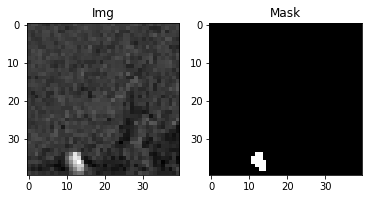

In [ ]:
display_img_mask(1,10)

### Test resizing 

In [ ]:
for images, masks in train_ds.take(1):  # only take first element of dataset
      numpy_images = images.numpy()
      numpy_masks = masks.numpy()

test_img = numpy_images[0]
test_img.shape

(40, 40, 3)

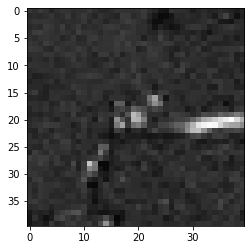

In [ ]:
plt.imshow(test_img)

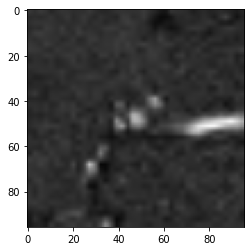

In [ ]:
# test_img_resized = tf.image.resize(test_img, size=(96,96,3), method=ResizeMethod.BILINEAR, preserve_aspect_ratio=False, antialias=False, name=None)
test_img_resized = tf.image.resize(test_img, size=(96,96))

plt.imshow(test_img_resized)

# Loss Function

In [ ]:
# return our metric and loss

with tpu_strategy.scope():

  def dice_coef(y_true, y_pred, smooth=1e-16):
    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    return (2* intersection + smooth)/(K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


  def dice_coef_loss(y_true, y_pred):

    return (1.0 - dice_coef(y_true, y_pred))


  def mixed_loss(y_true, y_pred):

    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = K.flatten(y_pred)

    bce = tf.keras.losses.binary_crossentropy(y_true_f, y_pred_f, from_logits=True)
    dice = dice_coef(y_true, y_pred)

    return bce + (1.0 - dice)

# Model Architecture

## Pre-trained model: original

In [ ]:
def rescale_output(y_pred):

  y_pred = tf.clip_by_value(y_pred, clip_value_min=0., clip_value_max=1.) # force values to be between 0 and 1

  return y_pred

In [ ]:
with tpu_strategy.scope(): 

  def unet_model(output_channels):

    inputs = tf.keras.layers.Input(shape=[40, 40, 3])
    resize_layer = tf.keras.layers.Lambda(lambda img: tf.image.resize(img, (96, 96)))
    x = resize_layer(inputs)

    # Downsampling through the model
    base_model = tf.keras.applications.MobileNetV2(input_shape=[96, 96, 3], include_top=False) # ImageNet weights only work with 3 channel images

    # adding regularization
    penalty = 0.0001
    regularizer = tf.keras.regularizers.l2(penalty)

    for layer in base_model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

     # When we change the layers attributes, the change only happens in the model config file
    model_json = base_model.to_json()

    # Save the weights before reloading the model.
    weights_path = "/content/drive/My Drive/Masters Project/Vascular Segmentation/Model Weights/test5.h5"
    # weights_path = os.path.join(weights_path, 'test1.h5')
    base_model.save_weights(weights_path)

    # load the model from the config
    base_model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    base_model.load_weights(weights_path, by_name=True)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 48x48
        'block_3_expand_relu',   # 24x24
        'block_6_expand_relu',   # 12x12
        'block_13_expand_relu',  # 6x6
        'block_16_project',      # 3x3
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

    down_stack.trainable = False

    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]


    skips = down_stack(x)
    x = skips[-1] # final output of encoder
    skips = reversed(skips[:-1]) # all outputs of encoder except final, reversed
    # Upsampling and establishing the skip connections
    
    for up, skip in zip(up_stack, skips):
      x = up(x) # pass output of encoder through decoder (iterates through outputs of decoder)
      concat = tf.keras.layers.Concatenate() 
      x = concat([x, skip]) # cross-link: output of decoder concatenated with encoder output
    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    normalise_output = tf.keras.layers.Lambda(rescale_output)

    x = last(x)
    shrinking_layer = tf.keras.layers.Lambda(lambda img: tf.image.resize(img, (40, 40)))
    x = shrinking_layer(x)
    # x = tf.keras.activations.sigmoid(x)
    x = normalise_output(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(output_channels=1)
model.summary()

9420800/9406464 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 40, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 96, 96, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
model (Functional)              [(None, 48, 48, 96), 1841984     lambda[0][0]                     
__________________________________________________________________________________________________
sequential (Sequential)         (None, 6, 6, 512)    1476608     model[0][4]                      
____________________________________________________________________________________________

# Learning Rate Scheduling & Early Stopping

In [ ]:
def build_learning_rate_cycler(
    lr_start=1e-5,
    lr_max=5e-5,
    lr_min=1e-6,
    lr_rampup_epochs=10,
    lr_sustain_epochs=2,
    lr_exp_decay=0.9,
):
    lr_max = lr_max

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay ** (
                epoch - lr_rampup_epochs - lr_sustain_epochs
            ) + lr_min
        return lr

    return lrfn

lr_cycler = build_learning_rate_cycler(
          lr_start=1e-5,
          lr_max=1e-2,
          lr_min=1e-6,
          lr_rampup_epochs=20,
          lr_sustain_epochs=0,
          lr_exp_decay=0.9,
      )   

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=20,
                    restore_best_weights=True,
                    mode='auto',
                )

# Find Optimal Learning Rate

In [ ]:
loss = dice_coef_loss
metrics = dice_coef

model = unet_model(output_channels=1)
model.compile(optimizer=Adam(), loss=loss, metrics=metrics)

initial_weights = model.get_weights()
len(initial_weights)

9420800/9406464 [==============================] - 0s 0us/step


273

In [ ]:
def find_learning_rate(num_rates=50):
    rates = np.logspace(-5, -1, num=num_rates)
    img, label = list(train_ds.take(1))[0]
    losses = []
    
    for rate in tqdm(rates):
          model.compile(optimizer=Adam(learning_rate=rate), loss=loss, metrics=metrics)
          model.set_weights(initial_weights)
          model.fit(img, label, epochs=5, verbose=0)
          losses.append(model.history.history['loss'][-1])
    return losses, rates

losses, rates = find_learning_rate(50)

  0%|          | 0/50 [00:00<?, ?it/s]

(array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05]),
 <a list of 10 Text major ticklabel objects>)

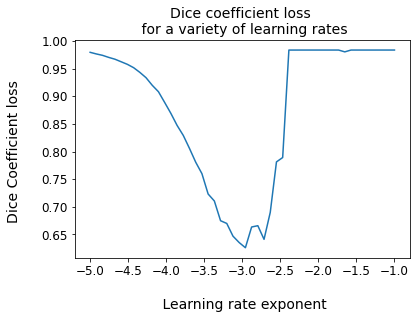

In [ ]:
plt.plot(np.log10(rates), np.clip(losses, 0, 2))
plt.title('Dice coefficient loss \n for a variety of learning rates', size=14)
plt.xlabel('\n Learning rate exponent', size=14)
plt.ylabel('Dice Coefficient loss \n', size=14)
plt.xticks(size=12)
plt.yticks(size=12)

# Training

In [ ]:
with tpu_strategy.scope():

  model = unet_model(output_channels=1)

  learning_rate = 10**(-3.15)
  loss = dice_coef_loss
  # loss = tf.keras.losses.binary_crossentropy
  # loss = mixed_loss
  metrics = dice_coef

  model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss,metrics=dice_coef)

  EPOCHS = 100

# train on aneurysm-positive only
  history = model.fit(
      train_ds.take(10), 
      epochs=EPOCHS,
      validation_data=val_ds.take(2), callbacks = [early_stopping]) # , tf.keras.callbacks.LearningRateScheduler(lr_cycler, verbose=1)

  save_model_path = "/content/drive/My Drive/Masters Project/Vascular Segmentation/Model Weights/Step2 40x40 bounding box/v2"
  model.save(os.path.join(save_model_path, 'lr=1e-3.15_l2(0.0001).h5'))

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/100
10/10 [==============================] - 25s 861ms/step - loss: 1.2848 - dice_coef: 0.0448 - val_loss: 1.2824 - val_dice_coef: 0.0471
Epoch 2/100
10/10 [==============================] - 2s 193ms/step - loss: 1.0773 - dice_coef: 0.2522 - val_loss: 1.2391 - val_dice_coef: 0.0905
Epoch 3/100
10/10 [==============================] - 2s 179ms/step - loss: 1.0011 - dice_coef: 0.3284 - val_loss: 1.2268 - val_dice_coef: 0.1028
Epoch 4/100
10/10 [==============================] - 3s 206ms/step - loss: 0.9571 - dice_coef: 0.3724 - val_loss: 1.2258 - val_dice_coef: 0.1038
Epoch 5/100
10/10 [==============================] - 2s 191ms/step - loss: 0.9331 - dice_coef: 0.3964 - val_loss: 1.2097 - val_dice_coef: 0.1198
Epoch 6/100
10/10 [==============================] - 3s 203ms/step - loss: 0.8939 - dice_coef: 0.4357 - val_loss: 1.2455 - val_dice_coef: 0.0840
Epoch 7/100
10/10 [==============================] - 2s 187ms/step - loss: 0.8930 - dice_coef: 0.4366 - val_loss: 1.2395 - val_di

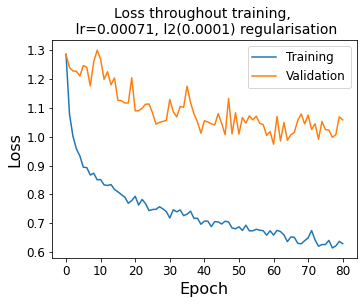

In [ ]:
plt.figure(figsize=(12, 4)) 

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch', size=16)
plt.ylabel('Loss', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Loss throughout training, \n lr={}, l2(0.0001) regularisation'.format(np.round(learning_rate, 5)), size=14)
plt.legend(prop={'size': 12})

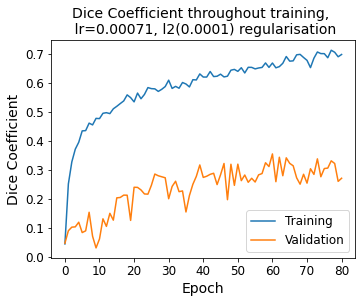

In [ ]:
plt.figure(figsize=(12, 4)) 

plt.subplot(1,2,2)
plt.plot(history.history['dice_coef'], label='Training')
plt.plot(history.history['val_dice_coef'], label='Validation')
plt.xlabel('Epoch', size=14)
plt.ylabel('Dice Coefficient', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Dice Coefficient throughout training, \n lr={}, l2(0.0001) regularisation'.format(np.round(learning_rate, 5)), size=14)
plt.legend(prop={'size': 12})

# Predict on single test image

In [ ]:
test_nonempty_gcs_pattern = "gs://40_bounding_box_step2_ver2/test_non_empty*"
test_nonempty_filenames = tf.io.gfile.glob(test_nonempty_gcs_pattern)

test_nonempty_ds = tf.data.TFRecordDataset(test_nonempty_filenames)
test_nonempty_ds = test_nonempty_ds.map(_parse_image_function)
test_nonempty_ds = test_nonempty_ds.map(_unpack_proto)
test_nonempty_ds = test_nonempty_ds.map(to_3_channels)

test_ds = prepare_data(test_nonempty_ds)

In [ ]:
test_images = []
test_masks = []

for batch_num in range(3):
  for images, masks in test_ds.take(batch_num):  
        numpy_images = images.numpy()
        numpy_masks = masks.numpy()

        test_images.append(numpy_images)
        test_masks.append(numpy_masks)

numpy_images = np.concatenate(test_images)
numpy_masks = np.concatenate(test_masks)

In [ ]:
numpy_images.shape

(192, 40, 40, 3)

Text(0.5, 1.0, 'Predicted mask for test image')

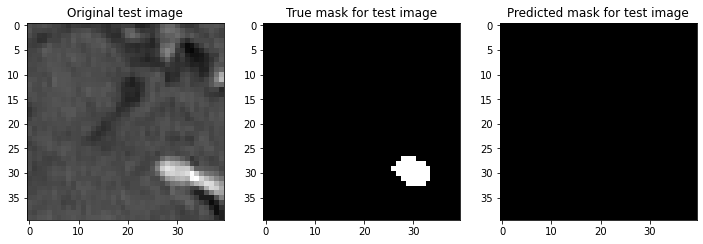

In [ ]:
plt.figure(figsize=(12, 4)) 

img_num=17

plt.subplot(1,3,1)
plt.imshow(numpy_images[img_num])
plt.title('Original test image')

plt.subplot(1,3,2)
plt.imshow(numpy_masks[img_num], cmap='gray')
plt.title('True mask for test image')

plt.subplot(1,3,3)
plt.imshow((model.predict(tf.expand_dims(numpy_images[img_num], axis=[0])))[0].reshape((40,40)), cmap='gray')
plt.title('Predicted mask for test image')

# Evaluate on whole test set

In [ ]:
print('Predicting masks on test data...')

test_preds = [model.predict(tf.expand_dims(image, axis=[0]))[0] for image in numpy_images]
# test_preds = np.concatenate(test_preds)
test_preds = np.array(test_preds)

Predicting masks on test data...


In [ ]:
# calculate dice coeff for each pair of true (test_masks) and predicted (test_preds) masks in the test set

dice_coeff_list = []
dice_coeff_dict = {}

for i in range(len(numpy_masks)):
  true_mask = numpy_masks[i]
  pred_mask = test_preds[i]
  pred_mask = np.round(pred_mask)

  dice_coeff = np.array(dice_coef(true_mask, pred_mask))
  dice_coeff_list.append(dice_coeff)
  dice_coeff_dict[i] = dice_coeff

np.mean(dice_coeff_list), np.std(dice_coeff_list)

(0.2081803, 0.26651737)

(0.0, 120.0)

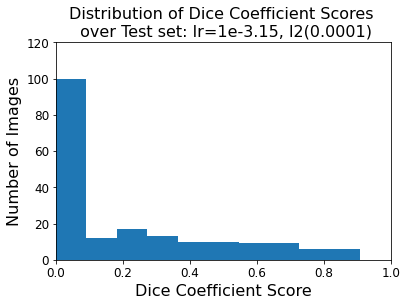

In [ ]:
plt.hist(dice_coeff_list)
plt.title('Distribution of Dice Coefficient Scores \n over Test set: lr=1e-3.15, l2(0.0001)', size=16)
plt.xlabel('Dice Coefficient Score', size=16)
plt.ylabel('Number of Images', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim([0,1])
plt.ylim([0,120])

In [ ]:
# create lists 'low' and 'high' that store indices of low and high scoring masks respectively

low = []
med = []
high = []

for key,val in dice_coeff_dict.items():
  if val<0.1:
    low.append(key)
  elif val<0.5 and val>0.3:
    med.append(key)
  elif val>0.5:
    high.append(key)


len(low), len(med), len(high)

(103, 22, 32)

In [ ]:
high

[18,
 38,
 39,
 49,
 55,
 59,
 63,
 69,
 72,
 75,
 86,
 88,
 100,
 104,
 107,
 113,
 119,
 124,
 127,
 144,
 148,
 149,
 157,
 163,
 165,
 166,
 172,
 175,
 178,
 179,
 183,
 187]

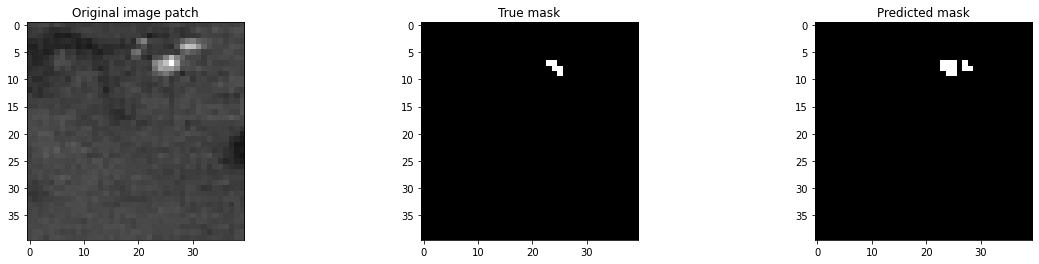

In [ ]:
compare_img_mask(39)

In [ ]:
def compare_img_mask(img_num):

  """
  Display original image with mask, true mask and predicted mask for a specified image number
  
  Args:
  train_, test_ or valid_ + images/masks/preds
  """
  
  plt.figure(figsize=(20, 4)) 

  plt.subplot(1,3,1)
  plt.imshow(numpy_images[img_num])
  plt.title('Original image patch')

  plt.subplot(1,3,2)
  plt.imshow(numpy_masks[img_num].reshape((40,40)), cmap='gray')
  plt.title('True mask')

  plt.subplot(1,3,3)
  plt.imshow(np.round(test_preds[img_num]).reshape((40,40)), cmap='gray')
  plt.title('Predicted mask')

## Hausdorff Distance

### scipy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.directed_hausdorff.html

scipy.spatial.distance.directed_hausdorff(u, v, seed=0): u and v are 2D input arrays of coordinates (presumably those of the aneurysms in the true and predicted masks)

In [ ]:
# calculate hausdorff dist for each pair of true (test_masks) and predicted (test_preds) masks in the test set

hausdorff_list = []
hausdorff_dict = {}

for i in range(len(numpy_masks)):
  true_mask = numpy_masks[i]
  pred_mask = test_preds[i]
  pred_mask = np.round(pred_mask)

  hausdorff_dist = directed_hausdorff(true_mask, pred_mask.reshape((40,40)))[0]
  hausdorff_list.append(hausdorff_dist)
  hausdorff_dict[i] = hausdorff_dist

np.mean(hausdorff_list), np.std(hausdorff_list)

(1.6195665791893943, 0.5924208207905066)

(0.0, 100.0)

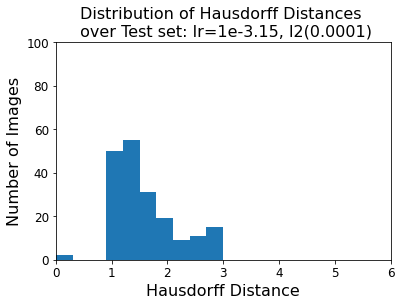

In [ ]:
plt.hist(hausdorff_list)
plt.title('Distribution of Hausdorff Distances \n over Test set: lr=1e-3.15, l2(0.0001)', size=16)
plt.xlabel('Hausdorff Distance', size=16)
plt.ylabel('Number of Images', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim([0,6])
plt.ylim([0,100])

In [ ]:
hausdorff_dict[10]

#  72, 80, 111, 118, 134, 159

3.0

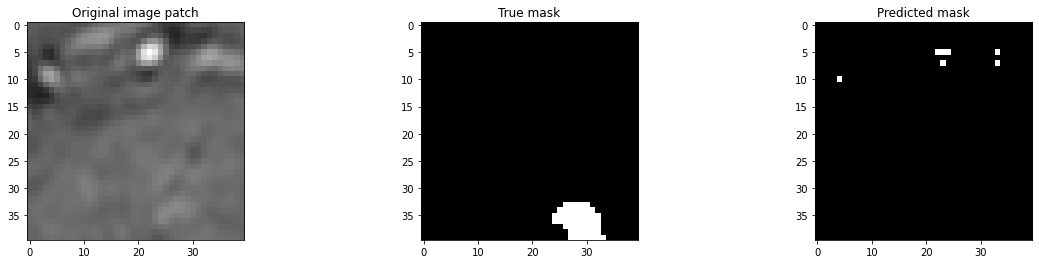

In [ ]:
compare_img_mask(10)

### SimpleITK: https://discourse.itk.org/t/computing-95-hausdorff-distance/3832/3